In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
import random

from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import gym
from gym.spaces import Discrete, Tuple

from env_mp_1 import MetaGames
from rmax_1 import RmaxAgent, Memory

def discretize(number, radius):
    #return (torch.round(torch.div(number, radius))) * radius
    #change made: originally: [0,3,6,9], now: [0,1,2,3]
    return torch.round(torch.div(number, radius))


In [2]:
inner_gamma = 0.8         #inner game discount factor
meta_gamma = 0.9          #meta game discount factor
meta_alpha = 0.4          #meta game learning rate
R_max = 0.98
max_meta_epi = 300
max_meta_steps = 50

epsilon = 0.2
radius = 1                #radius for discretization, assuming radius>1

#reward tensor for plotting purposes [episode, step, agents]
plot_rew = torch.zeros(max_meta_epi, max_meta_steps, 2).to(device)    

# creating environment
env = MetaGames("NL", "IPD")

memory = Memory()
rmax = RmaxAgent(env, R_max, meta_gamma, inner_gamma, radius, epsilon)

In [3]:
for episode in tqdm(range(max_meta_epi)): #for each meta-episode
    #initialise meta-state and meta-action randomly
    meta_s = rmax.index_to_table(env, random.randint(0, rmax.meta_size * env.num_agents), env.num_agents)
    memory.states.append(meta_s)

    #meta_a = rmax.index_to_table(env, random.randint(0, rmax.meta_size), 1)
    #memory.actions.append(meta_a)    
    
    for step in range(max_meta_steps):    #for each meta time step
        #env.innerq = meta_s.detach().clone()    #previous meta-state set as the policy of the next game
        env.innerq = meta_s.detach().clone() #
        #--------------------------------------START OF INNER GAME--------------------------------------
        #reset environment 
        env.reset()   

        #select inner-action with epsilon greedy 
        best_action = env.select_action().detach().clone()      

        #run inner game according to best_action
        reward, info = env.step(best_action)  

        #update inner r matrix [agent, action]
        env.innerr[0, int(best_action[0])] = reward.detach().clone() 
        env.innerr[1, int(best_action[1])] = info.detach().clone()

        #---------------------------------------END OF INNER GAME--------------------------------------
        #save reward, info for plotting              
        plot_rew[episode,step,0] += reward.detach().clone()
        plot_rew[episode,step,1] += info.detach().clone()
        
        #meta-action = inner game Q table of our agent
        meta_a = env.innerq[0, :].detach().clone()
        memory.actions.append(meta_a) 
        
        #Compute new inner Q table, our agent: by Q learning, oppo: max of Q table by putting in previous meta-s
        env.innerq[0, :] = meta_alpha * env.innerq[0, :] + (1 - meta_alpha) * env.innerq[0, :]
        env.innerq[1, :] = rmax.index_to_table(env, int(torch.argmax(rmax.Q[rmax.find_meta_index(torch.flatten(meta_s)),:]).detach()), 1)
        
        #meta-state = discretized inner game Q table of all agents
        new_meta_s = discretize(env.innerq.detach().clone(), radius)
        memory.states.append(new_meta_s)    
        
        #meta-reward = sum of rewards of our agent in inner game of K episodes & T timesteps
        our_REW = reward.detach().clone()                
        memory.rewards.append(reward)
        
        #rmax update step
        rmax.update(env, memory, meta_s, meta_a, new_meta_s)
        
        #prepare meta_s for next step
        meta_s = new_meta_s.detach().clone()


100%|██████████████████████████████████████████████████████████| 300/300 [03:28<00:00,  1.44it/s]


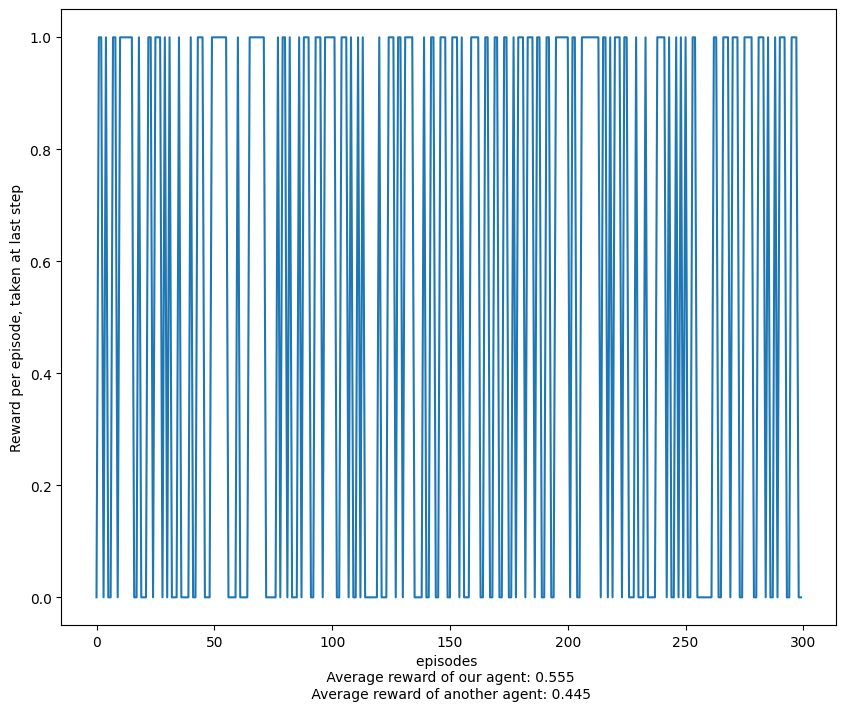

In [6]:
plot_rew_us = plot_rew[:,-1,0] 
plot_rew_others = plot_rew[:,-1,1],
fig_handle = plt.plot(plot_rew_us.cpu().numpy())

plt.xlabel("episodes \n Average reward of our agent: " + str(round(torch.mean(plot_rew[:,:,0],(0,1)).detach().item(), 3)) + 
          "\n Average reward of another agent: " + str(round(torch.mean(plot_rew[:,:,1],(0,1)).detach().item(), 3)))

plt.ylabel("Reward per episode, taken at last step")

figure = plt.gcf() # get current figure
figure.set_size_inches(10, 8)

#plt.savefig('inner_gamma' + str(inner_gamma) + '_rad' + str(radius) + '_' + str(max_meta_epi) + '_' + str(max_meta_steps) + '_mp1.png' , dpi = 100)

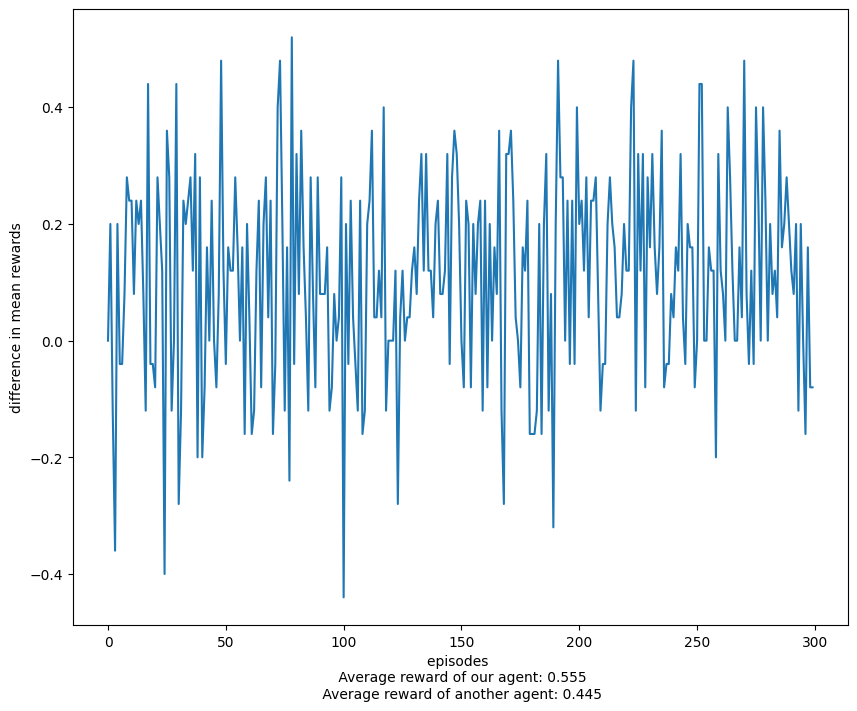

In [5]:
plot_rew_mean_diff = torch.mean(plot_rew[:,:,0],1) - torch.mean(plot_rew[:,:,1],1)
fig_handle = plt.plot(plot_rew_mean_diff.cpu().numpy())

plt.xlabel("episodes \n Average reward of our agent: " + str(round(torch.mean(plot_rew[:,:,0],(0,1)).detach().item(), 3)) + 
          "\n Average reward of another agent: " + str(round(torch.mean(plot_rew[:,:,1],(0,1)).detach().item(), 3)))

plt.ylabel("difference in mean rewards")

figure = plt.gcf() # get current figure
figure.set_size_inches(10, 8)

plt.savefig('inner_gamma' + str(inner_gamma) + '_rad' + str(radius) + '_' + str(max_meta_epi) + '_' + str(max_meta_steps) + '_mp1.png' , dpi = 100)

# OLD VERSION (PLS DELETE IF ABOVE WORKS)

In [ ]:
for episode in tqdm(range(max_meta_epi)): #for each meta-episode
    #initialise meta-state and meta-action as zeros
    meta_s = torch.zeros(env.b, env.num_actions, env.num_agents).to(device) 
    memory.states.append(meta_s)
    meta_a = torch.zeros(env.b, env.num_actions).to(device) 
    memory.actions.append(meta_a)    
    
    for step in range(max_meta_steps):    #for each meta time step
        env.innerq = meta_s.detach().clone()    #previous meta-state set as the policy of the next game
        
#--------------------------------------INNER GAME--------------------------------------
        for epi in range(max_inner_epi):              #for each inner episodes 
            #print("inner episode =", epi, meta_s)
            #state = env.reset()   #reset environment 
            env.reset()   #reset environment 
            
            for t in range(max_inner_steps):                     #for each inner timestep
                #print("inner timestep =", t)
                if epi == 0 & t == 0:
                    #initialised action 
                    best_action = env.init_action.detach().clone()
                else:
                    #find action that has max Q value for current state for both agents
                    best_action = env.choose_action()

                #run inner game according to that action, for K episodes & T timesteps, output used to be new_state, reward, done, _ 
                reward, info = env.step(best_action)  
                
                #update inner r matrix
                for i in range(env.b):
                    #env.innerr[i, state[i], best_action[0,i], 0] = reward[i] 
                    #env.innerr[i, state[i], best_action[1,i], 1] = info[i]
                    env.innerr[i, best_action[0,i], 0] = reward[i].detach().clone() 
                    env.innerr[i, best_action[1,i], 1] = info[i].detach().clone()

                    
                #update inner q matrix, another for loop since have to wait till inner r matrix gets updated    
                for i in range(env.b):    
                    #env.innerq[i, state[i], best_action[0,i], 0] = env.innerr[i, state[i], best_action[0,i], 0] + inner_gamma * torch.max(env.innerq[i, newstate[i], :, 0]) 
                    #env.innerq[i, state[i], best_action[1,i], 1] = env.innerr[i, state[i], best_action[1,i], 1] + inner_gamma * torch.max(env.innerq[i, newstate[i], :, 1])
                    env.innerq[i, best_action[0,i], 0] = env.innerr[i, best_action[0,i], 0].detach().clone() + inner_gamma * torch.max(env.innerq[i, :, 0]).detach().clone()
                    env.innerq[i, best_action[1,i], 1] = env.innerr[i, best_action[1,i], 1].detach().clone() + inner_gamma * torch.max(env.innerq[i, :, 1]).detach().clone()
                #set current state = new state
                #state = newstate  
                
                #save reward, info for plotting              
                plot_rew[episode,step,0,:] += reward.detach().clone()
                plot_rew[episode,step,1,:] += info.detach().clone()
        
        #meta-state = inner game Q table for all agents
        new_meta_s = discretize(env.innerq.detach().clone(), radius)
        #meta-action = inner game Q table for our agent
#       new_meta_a = discretize(env.innerq[:,:,0].detach().clone(), radius)     
        new_meta_a = rmax.select_action(new_meta_s)
         
        our_REW = reward.detach().clone()                #meta-reward = sum of rewards of our agent in inner game of K episodes & T timesteps
        memory.rewards.append(reward)
        #print("meta step=", step, meta_s, meta_a, new_meta_s)
        rmax.update(env, memory, meta_s, meta_a, new_meta_s)
        
        meta_s = new_meta_s
        meta_a = new_meta_a

        
